In [1]:
import sys
import os
# sys.path.append('/home/beinhaud/diplomka/mcs-source/evaluation_tools')
sys.path.append('/home/david/source/diplomka/evaluation_tools')
sys.path.append('/home/david/source/diplomka/results_analysis_tools')


from evaluation_tools.plugins.predictions_analyzer import PredictionsAnalyzer
from evaluation_tools.plugins.wandb_processor import WandbProcessor
from evaluation_tools.fields.experiment_parameters_fields import WandbExperimentVariants, GridSearchRunVariants, ModelEvaluationRunVariant, AdditionalExperiments
from evaluation_tools.fields.prediction_analysis_fields import (
    BatchSummaryFields,
    EvaluationPairsVariants,
)
from evaluation_tools.fields.dataset_analyzer_fields import AnalysisFields, DatasetVariantField
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices
from nn_model.type_variants import EvaluationFields
import nn_model.globals

import pandas as pd
import numpy as np

from results_analysis_tools.result_analyzer import ResultAnalyzer
from evaluation_tools.fields.dataset_parameters import ALL_TIME_STEP_VARIANTS
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
    PluginVariants,
)
from results_analysis_tools.results_plotter import ResultsPlotter


In [2]:
PLOTING_DESTINATION = "/home/david/source/diplomka/thesis_plots/"
EVALUATION_RESULTS_BASE = "/analysis_results"
analysis_paths = {
    EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.FULL_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS.value}/",
    # EvaluationProcessorChoices.WANDB_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.WANDB_ANALYSIS.value}/",
    EvaluationProcessorChoices.PREDICTION_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.PREDICTION_ANALYSIS.value}/",
}
result_analyzer = ResultAnalyzer(analysis_paths)
all_results = result_analyzer.get_all_results



# Time Bin Spike Counts

In [3]:
counts = result_analyzer.get_mean_spike_counts(False)

In [4]:
# result_analyzer = ResultAnalyzer(analysis_paths)
counts_test = result_analyzer.get_mean_spike_counts(is_test=True)

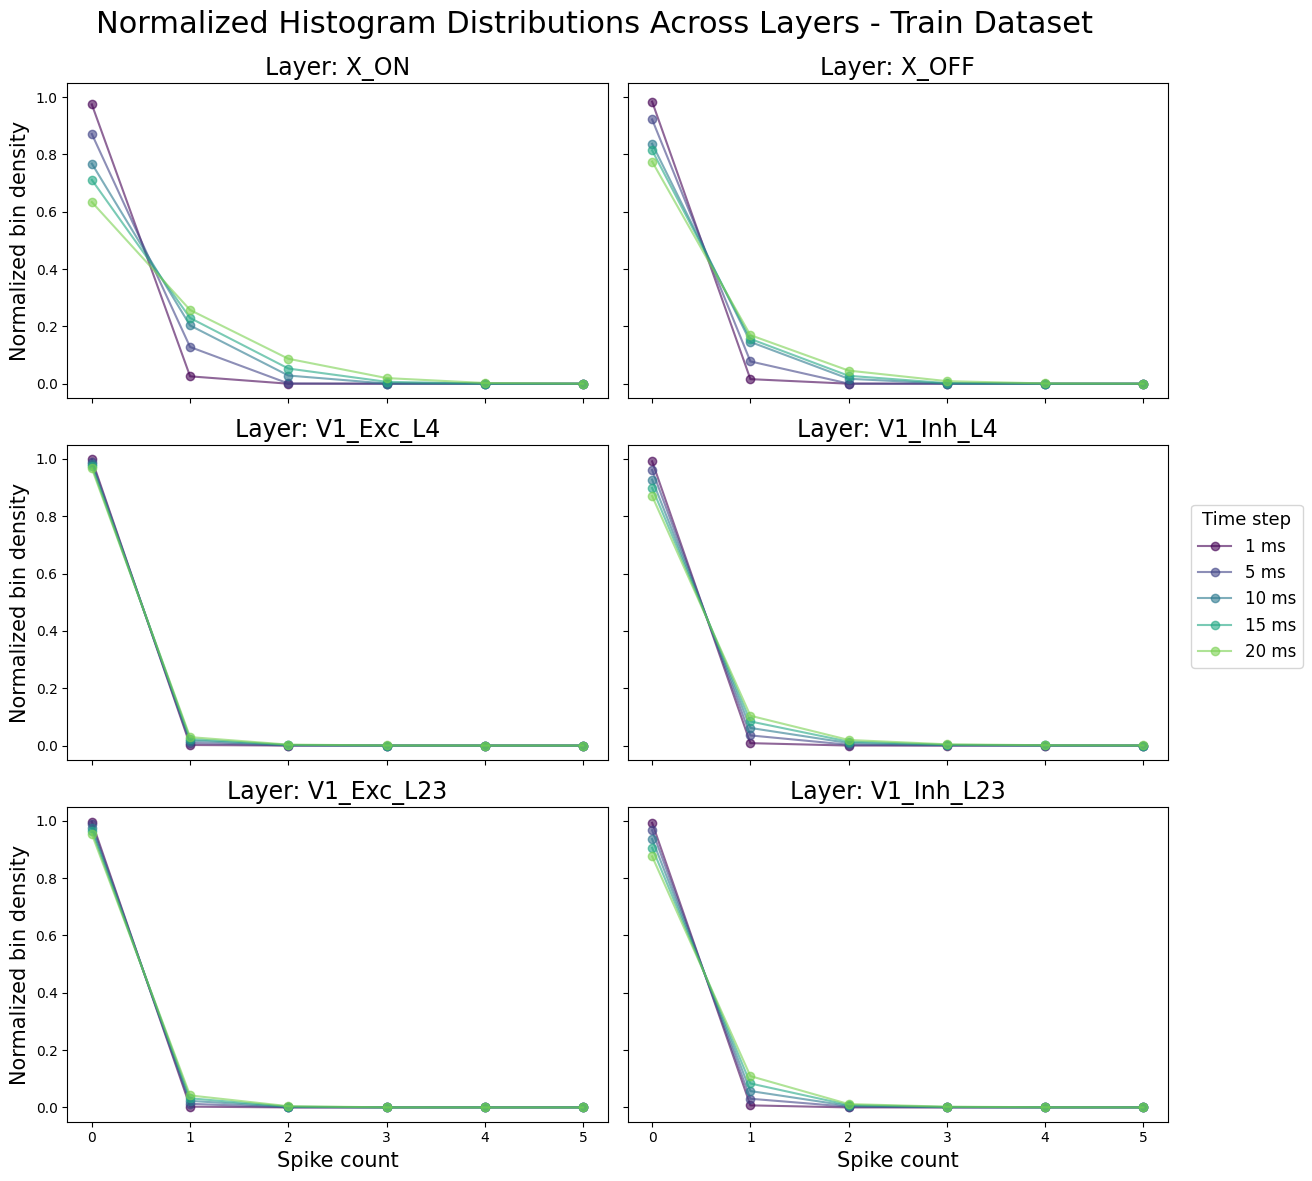

In [5]:
is_test = False
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")

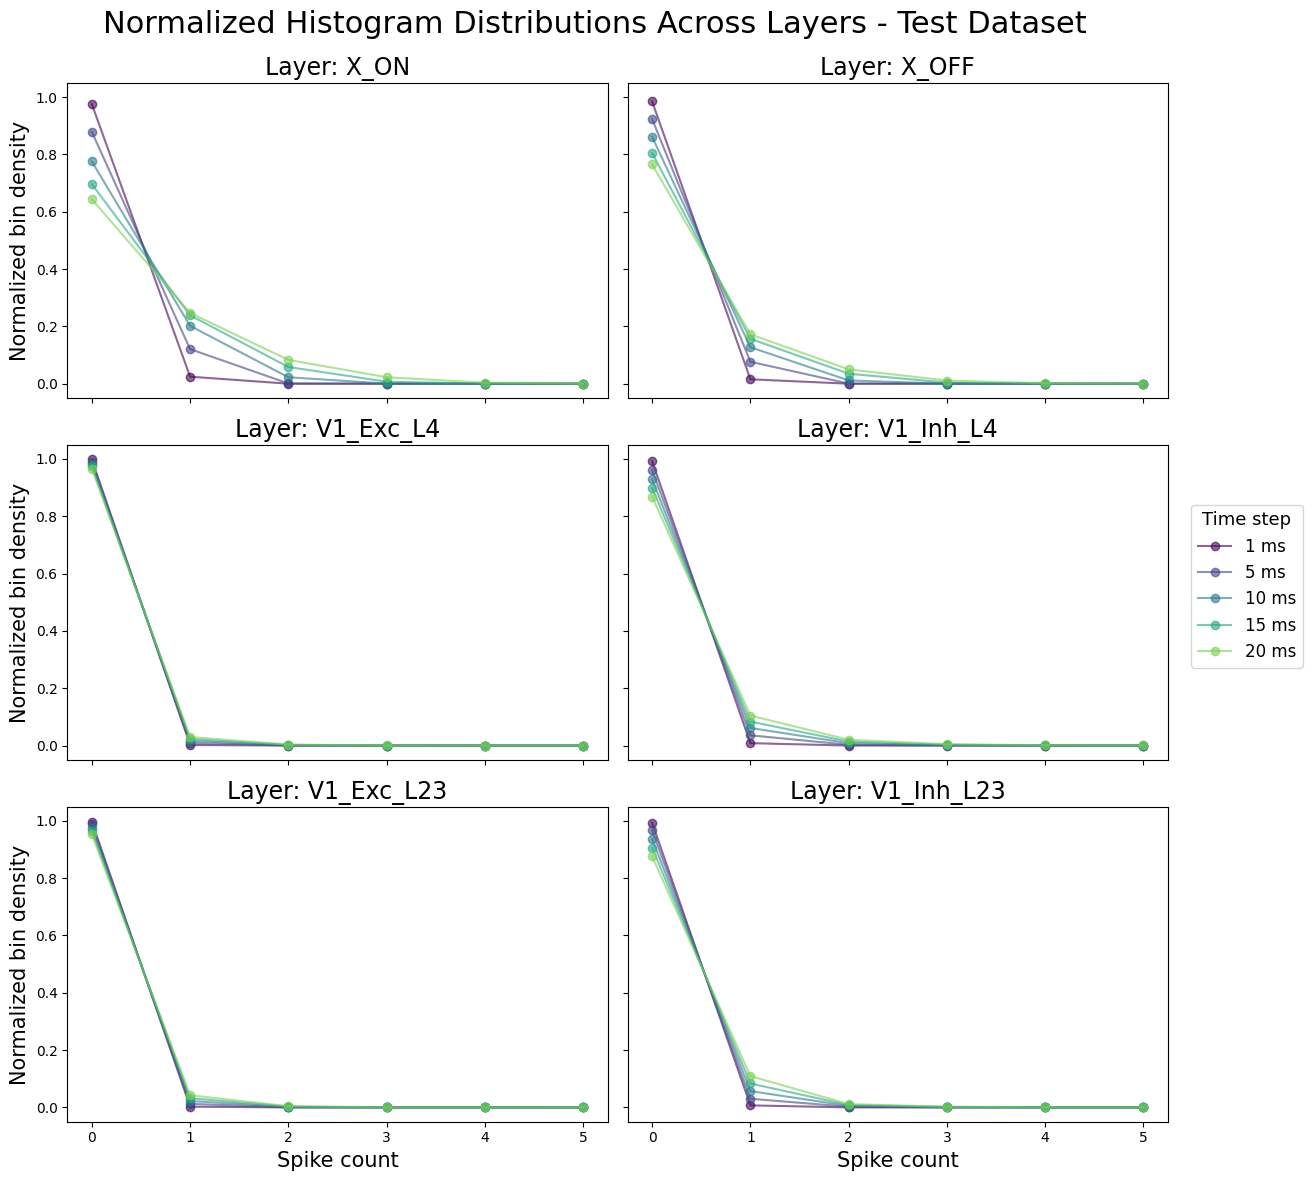

In [7]:
is_test = True
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")